In [5]:
!jt -t grade3 -tf ubuntu -tfs 12 -nf sourcesans -nfs 10 -f dejavu

# Predicting the cell price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem definition
> How well can we predict the future price of bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data
The data is downloaded from Kaggle's bluebook competition.
The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.

* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 * You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.

* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

* The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale

* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
saleprice: what the machine sold for at auction (only provided in train.csv)
saledate: the date of the sale

* There are several fields towards the end of the file on the different options a machine can have.  The descriptions all start with "machine configuration" in the data dictionary.  Some product types do not have a particular option, so all the records for that option variable will be null for that product type.  Also, some sources do not provide good option and/or hours data.
* The machine_appendix.csv file contains the correct year manufactured for a given machine along with the make, model, and product class details. There is one machine id for every machine in all the competition datasets (training, evaluation, etc.).

## 3. Evaluation
The evaluation Metric for this competition will be the RMSLE (Root Mean Squared Log Error) between the actual and predicted auction prices.

For more on the evaluation of this project check:

*https://www.kaggle.com/c/bluebook-for-bulldozers/rules*

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model minimizes RMSLE.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on google sheets.
The link:

*https://www.kaggle.com/c/bluebook-for-bulldozers/data*


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score

In [3]:
# Import training and validation sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum() # Will give number of missing items in each row

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

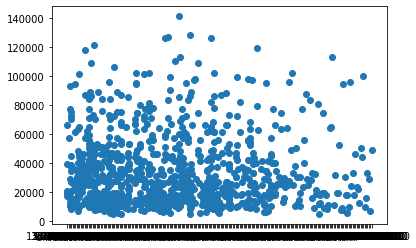

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

<AxesSubplot:ylabel='Frequency'>

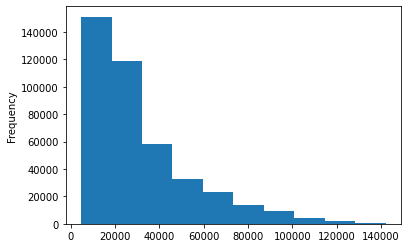

In [7]:
df.SalePrice.plot.hist()

### Parsing dates

1.When we work with time series data, we want to enrich the time & date component as much as possible.

2. We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter

In [8]:
# Import data but this time pass dates
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

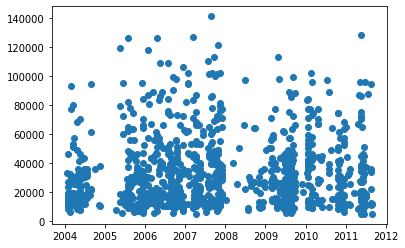

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [13]:
df['saledate'].head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort dataframe by saledate

when working with time series data, it's a good idea to sort it by date.


In [14]:
# Sort DataFrame by date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(50)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
144032   1989-01-31
54438    1989-01-31
144952   1989-01-31
205752   1989-01-31
28927    1989-01-31
86971    1989-01-31
67034    1989-01-31
87602    1989-01-31
53101    1989-01-31
205784   1989-01-31
101796   1989-01-31
54181    1989-01-31
28757    1989-01-31
77792    1989-01-31
134119   1989-01-31
98346    1989-01-31
119449   1989-01-31
119199   1989-01-31
92833    1989-01-31
77650    1989-01-31
119369   1989-01-31
98567    1989-01-31
135284   1989-01-31
63155    1989-01-31
142669   1989-01-31
63166    1989-01-31
63167    1989-01-31
127300   1989-01-31
67974    1989-01-31
140257   1989-01-31


### Make a copy of our original DataFrame
We make a copy of the original DataFrame so when we manipulate the copy, we've still got our original DataFrame.

In [15]:
# Make a copy 
df_tmp = df.copy()

In [16]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add datetime parameters for `saledate` column

In [17]:
# Access the saledate
df_tmp[:1].saledate

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [18]:
# Access the saledate day
df_tmp[:1].saledate.dt.day

205615    17
Name: saledate, dtype: int64

In [19]:
# Access the saledate year
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int64

In [20]:
# Access the saledate month
df_tmp[:1].saledate.dt.month

205615    1
Name: saledate, dtype: int64

In [21]:
# Creating separate columns for each day, month and year
df_tmp["saleYear"] = db
f_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [22]:
df_tmp.head();

In [23]:
# Now we've enriched our DataFrame with date time feautures we can remove saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [24]:
# Check the values of different columns 
# EDA - Exploratory Data Analysis
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## Modelling
We've done enough EDA (we could anyways do more) but let's start to do some model-driven EDA

In [25]:
# Let's build a machine learning model.

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)

# X = df_tmp.drop("SalePrice", axis=1)
# y = df_tmp["SalePrice"]
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

# Convert string to categories.
One way we can turn all of our data into numbers is by converting then into pandas categories.

In [26]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [27]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [28]:
# This will turn all of the string value into category values

for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

> What this loop does is, it treats the label as key and all the values under the label as values and hence when the 'content' (value) is detected to be an object then the 'if' condition becomes 'True' and it converts the object type to pandas category type.

 The reason we are converting object to pandas categories is :
    
   - The category data type in pandas is a hybrid data type. It looks and behaves like a string in many instances but internally is represented by an array of integers. This allows the data to be sorted in a custom order and to more efficiently store the data.


In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [30]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

Under the hood, pandas is treating this list as numbers

In [31]:
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Thanks to pandas categories we now have a way to acces all of our data in the form of numbers.

But we will still have a whole bunch of missing data.

In [32]:
# Check the missing data
df_tmp.isnull().sum()/len(df_tmp)

# The below table will give what fraction of data is missing in each column.
# For example, 'UsageBand' has 0.821492 (82.15%) of missing data.

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### Save preprocessed data

In [33]:
# Export current df_tmp DataFrame to a csv file.
df_tmp.to_csv("data/train-temp.csv", index=False)

In [34]:
# Import preprocessed data
df_tmp = pd.read_csv("data/train-temp.csv", low_memory=False)

df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill Missing Values
### Fill numeric values first

In [35]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print()

In [168]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Add a binary column which tells us if the data is missing
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

**Why we used Median instead of Mean?**
> Consider there is an array of people who have money ranging from 0 to 100 so the Mean representing the average amout of money will be in between 0 and 100. So far so good! But as soon as a man with a 1,000,000,000 dollars enters the room, the mean will drastically change and the average of a person having money will drastically change. Though someone having 42 dollars will be represented by an average of 999,999,951 dollars which will be unfair hence we use median.

In [169]:
# Chek id there is any null numeric values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [170]:
# Check to see how many examples were missing.
df_tmp['auctioneerID is missing'].value_counts()

False    392562
True      20136
Name: auctioneerID is missing, dtype: int64

In [171]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting is missing     0
Blade_Type is missing           0
Travel_Controls is missing      0
Differential_Type is missing    0
Steering_Controls is missing    0
Length: 103, dtype: int64

### Filling and turning categorical variables into numbers

In [167]:
# Check for coulumns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

In [41]:
df_tmp;

In [42]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column ti indicate whethter sample had a missing value
        df_tmp[label+" is missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes + 1

In [43]:
pd.Categorical(df_tmp["UsageBand"]).codes
# This will turn state (pandas categorical variable) type to numeric type

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

* Why to add '+1' in the above assignment?

>The way categories works is when there is missing value it assigns that to '-1'. But we don't want it to be '-1' we want it to be 0.

> For example, as shown above cell, in the 'UsageBand' column mostly there are 'NaN' values and Pandas Categories converts it to -1. But by adding +1 we convert it to 0.

In [44]:
pd.Categorical(df_tmp["state"]).codes + 1

array([44,  9,  9, ...,  5,  5,  5], dtype=int8)

We want pandas categories to assign 'Nan' value to 0 and let other values whatever categories want them to be. We just don't want any negative value. Because when value is any positive number other than 0, it is True and when it is 0, it is False.

In [45]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls is missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [46]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting is missing,False,True,False,True,False
Blade_Type is missing,False,True,False,True,False
Travel_Controls is missing,False,True,False,True,False
Differential_Type is missing,True,False,True,False,True


In [47]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting is missing     0
Blade_Type is missing           0
Travel_Controls is missing      0
Differential_Type is missing    0
Steering_Controls is missing    0
Length: 103, dtype: int64

Now our data has no null/NaN values and it has been turned into median values (if numerical data) and 0 if categorical values.

In [48]:
df_tmp

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width is missing,Stick_Length is missing,Thumb is missing,Pattern_Changer is missing,Grouser_Type is missing,Backhoe_Mounting is missing,Blade_Type is missing,Travel_Controls is missing,Differential_Type is missing,Steering_Controls is missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,0,2101,...,True,True,True,True,True,False,False,False,True,True
412694,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,0,240,...,True,True,True,True,True,True,True,True,True,True
412695,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,0,627,...,True,True,True,True,True,True,True,True,True,True
412696,6266251,55000.0,509560,3357,149,99.0,1993,0.0,0,83,...,True,True,True,True,True,True,True,True,True,True


In [49]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting is missing     0
Blade_Type is missing           0
Travel_Controls is missing      0
Differential_Type is missing    0
Steering_Controls is missing    0
Length: 103, dtype: int64

### Now that we have no missing values, now we are able to make a machine learning model to predict the bulldozer model.

In [50]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width is missing,Stick_Length is missing,Thumb is missing,Pattern_Changer is missing,Grouser_Type is missing,Backhoe_Mounting is missing,Blade_Type is missing,Travel_Controls is missing,Differential_Type is missing,Steering_Controls is missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [51]:
# %%time
# # Insstantiate model
# model = RandomForestRegressor(n_jobs=-1, random_state=69)

# # Fit the model
# model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

In [52]:
# # Score the model
# model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

**Question:** Why doesn't the above metric hold water? (why isn't the metric reliable) 

### Splitting data into train/validation sets

In [53]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width is missing,Stick_Length is missing,Thumb is missing,Pattern_Changer is missing,Grouser_Type is missing,Backhoe_Mounting is missing,Blade_Type is missing,Travel_Controls is missing,Differential_Type is missing,Steering_Controls is missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [54]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [55]:
# Spli data in training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [56]:
# Split data into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

In [57]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an Evaluation Function

In [58]:
# Create evaluation function (the competition uses RMSE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error betwween predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create a function to evaluate model of few different levels.
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {
        "Traning MAE": mean_absolute_error(y_train, train_preds),
        "Valid MAE": mean_absolute_error(y_valid, val_preds),
        "Training RMSLE": rmsle(y_train, train_preds),
        "Valid RMSLE": rmsle(y_valid, val_preds),
        "Training r^2": r2_score(y_train, train_preds),
        "Valid r^2": r2_score(y_valid, val_preds)
    }
    return scores


### Testing our model on a subset (to tune the hyperparameters)

In [59]:
# # This takes a lot of time

# %%time
# model = RandomForestRegressor(n_jobs=-1, random_state=42)

# model.fit(X_train, y_train)

In [60]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)
# max_samples will reduce the numbers of the samples given to the model, in this case, by default there are len(x_train) samples 

In [61]:
X_train.shape[0]

401125

In [62]:
%%time
# Cutting down on the max numbers of sampples each estimator can improve training time.
model.fit(X_train, y_train)

Wall time: 9.91 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [66]:
show_scores(model)

{'Traning MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training r^2': 0.8606658995199189,
 'Valid r^2': 0.8320374995090507}

In [68]:
### Hyperparameter tuning with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000]
}

# Instantiate RandomizedSearchCV
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_distributions=rf_grid, n_iter=2, cv=5, verbose=True)

# Fit the randomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [69]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 50,
 'min_samples_split': 12,
 'min_samples_leaf': 17,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 5}

In [70]:
# Evaluate the Randomizedsearch model
show_scores(rs_model)

{'Traning MAE': 11780.28266861656,
 'Valid MAE': 13657.718700469743,
 'Training RMSLE': 0.5063615070688876,
 'Valid RMSLE': 0.5189186962464523,
 'Training r^2': 0.4842333071407525,
 'Valid r^2': 0.4817404318121927}

### Train a model with best hyperparameters
**Note:** These were found after 100 iterations of `RandomizedSearchCV`

In [75]:
%%time
# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, min_samples_leaf=1, min_samples_split=14, max_features=0.5, n_jobs=-1, max_samples=None, random_state=42)
# Random state parameter so that our results are reproducible.
# Fit the model
ideal_model.fit(X_train, y_train)

Wall time: 1min


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1)

In [77]:
# Scores on rs_model (only trained on ~10,000 examples)
show_scores(ideal_model)

{'Traning MAE': 2959.4820843627585,
 'Valid MAE': 5969.202953408747,
 'Training RMSLE': 0.14486243266303586,
 'Valid RMSLE': 0.24774400344860578,
 'Training r^2': 0.9587591101422883,
 'Valid r^2': 0.8818377200212951}

In [78]:
show_scores(rs_model)

{'Traning MAE': 11780.28266861656,
 'Valid MAE': 13657.718700469743,
 'Training RMSLE': 0.5063615070688876,
 'Valid RMSLE': 0.5189186962464521,
 'Training r^2': 0.4842333071407525,
 'Valid r^2': 0.4817404318121927}

## Make predictions on test data.

In [189]:
# Import the test data.
df_test = pd.read_csv("data/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [158]:
# Make predictions of the test dataset.
test_preds = ideal_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

In [159]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [160]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Undercarriage_Pad_Width is missing', 'Stick_Length is missing',
       'Thumb is missing', 'Pattern_Changer is missing',
       'Grouser_Type is missing', 'Backhoe_Mounting is missing',
       'Blade_Type is missing', 'Travel_Controls is missing',
       'Differential_Type is missing', 'Steering_Controls is missing'],
      dtype='object', length=102)

## Preprocessing the data (getting the test dataset in the same format as our training dataset)


In [192]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [191]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [179]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,MachineHoursCurrentMeter is missing
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,...,NaN,NaN,NaN,NaN,2012,5,3,3,124,False
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,...,NaN,NaN,Standard,Conventional,2012,5,10,3,131,False
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,...,NaN,NaN,NaN,NaN,2012,5,10,3,131,False
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,...,NaN,NaN,NaN,NaN,2012,5,10,3,131,False
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,...,PAT,None or Unspecified,NaN,NaN,2012,5,10,3,131,False


In [122]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width is missing,Stick_Length is missing,Thumb is missing,Pattern_Changer is missing,Grouser_Type is missing,Backhoe_Mounting is missing,Blade_Type is missing,Travel_Controls is missing,Differential_Type is missing,Steering_Controls is missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [123]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

In [125]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width is missing,Stick_Length is missing,Thumb is missing,Pattern_Changer is missing,Grouser_Type is missing,Backhoe_Mounting is missing,Blade_Type is missing,Travel_Controls is missing,Differential_Type is missing,Steering_Controls is missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [194]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'Backhoe_Mounting is missing',
 'Blade_Extension is missing',
 'Blade_Type is missing',
 'Blade_Width is missing',
 'Coupler is missing',
 'Coupler_System is missing',
 'Differential_Type is missing',
 'Drive_System is missing',
 'Enclosure is missing',
 'Enclosure_Type is missing',
 'Engine_Horsepower is missing',
 'Forks is missing',
 'Grouser_Tracks is missing',
 'Grouser_Type is missing',
 'Hydraulics is missing',
 'Hydraulics_Flow is missing',
 'MachineHoursCurrentMeter is missing',
 'Pad_Type is missing',
 'Pattern_Changer is missing',
 'ProductGroup is missing',
 'ProductGroupDesc is missing',
 'ProductSize is missing',
 'Pushblock is missing',
 'Ride_Control is missing',
 'Ripper is missing',
 'Scarifier is missing',
 'Steering_Controls is missing',
 'Stick is missing',
 'Stick_Length is missing',
 'Thumb is missing',
 'Tip_Control is missing',
 'Tire_Size is missing',
 'Track_Type is missing',
 'Transmission is missing',
 'Travel_Controls is missing',
 'Turbocharged is missin

In [195]:
# Manually adjust df_test to have auctioneerID_is_missing columns
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our datframe has the same features as our training dataframe, we can make predictions!

In [197]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [198]:
test_preds

array([19305.49065851, 19112.81427433, 45226.3618877 , ...,
       14700.68223471, 16491.23835785, 28715.01263413])

In [199]:
len(test_preds)

12457

We are yet to convert the predictions into the form that Kaggle wants

In [201]:
# Format predictions into the same format Kaggle is wants
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,19305.490659
1,1227844,19112.814274
2,1227847,45226.361888
3,1227848,58236.124798
4,1227863,48399.487372
...,...,...
12452,6643171,44162.752326
12453,6643173,13600.745794
12454,6643184,14700.682235
12455,6643186,16491.238358


In [202]:
# Export prediction data
df_preds.to_csv("data/test_predictions.csv")

## Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting **the target** variables

In [204]:
ideal_model.feature_importances_

array([3.34623327e-02, 1.89852776e-02, 4.58746089e-02, 1.56398138e-03,
       3.33175965e-03, 1.98662698e-01, 3.08491003e-03, 1.08076110e-03,
       4.15736361e-02, 5.43590928e-02, 6.64857883e-02, 5.13150504e-03,
       1.55321506e-02, 1.65239319e-01, 3.87660631e-02, 5.97464221e-03,
       3.15398999e-03, 1.41336199e-03, 4.55678274e-03, 6.63077835e-02,
       6.46316357e-04, 6.03551949e-05, 1.59730695e-03, 2.22947178e-04,
       9.27816565e-04, 2.86080064e-05, 5.13153007e-04, 8.21899393e-03,
       4.85581295e-03, 6.09725299e-03, 5.06969633e-03, 1.90159248e-03,
       5.89994477e-03, 9.74755854e-04, 4.63743427e-04, 4.21087500e-03,
       8.56300157e-04, 1.49763006e-02, 2.99655167e-03, 5.22585829e-04,
       1.12399646e-03, 1.02294818e-03, 2.01208434e-03, 5.76126761e-04,
       8.15588579e-04, 3.52359944e-04, 2.11298017e-04, 1.78352328e-03,
       9.72388791e-04, 2.89665873e-04, 3.89407106e-04, 7.29944555e-02,
       3.78929393e-03, 5.68169529e-03, 2.89791940e-03, 9.90308746e-03,
      

In [216]:
# Helper function for plotting feature importance
def plt_features(columns, importances, n=20):
    df = (pd.DataFrame({
        "features": columns,
        "feature_importances": importances
    }).sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # Plot the dataframe we created
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

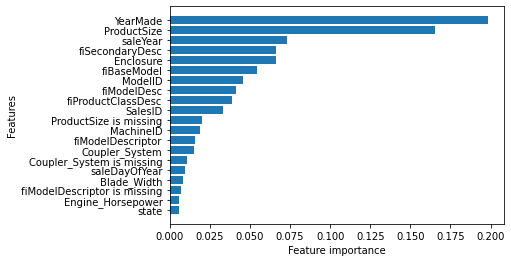

In [217]:
plt_features(X_train.columns, ideal_model.feature_importances_)

## **Quesion to finish:** Why might knowing the feature importance of a trained machine learning model be useful?